In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
cwd = Path(".")
data_dir = Path("../data")

In [9]:
!ls {data_dir}

metadata.csv  submission_format.csv  train_labels.csv


In [10]:
meta = pd.read_csv(data_dir/"metadata.csv")
label = pd.read_csv(data_dir/"train_labels.csv")

In [11]:
meta.shape, label.shape

((23570, 5), (17060, 4))

In [12]:
meta.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [17]:
meta["date"] = pd.to_datetime(meta["date"])

In [18]:
meta.describe(include="O")

,uid,split
count,23570,23570
unique,23570,2
top,aabm,train
freq,1,17060


In [19]:
meta.dtypes

uid                  object
latitude            float64
longitude           float64
date         datetime64[ns]
split                object
dtype: object

In [21]:
meta.groupby(meta.date.dt.year).size()

date
2013    1883
2014    2106
2015    2826
2016    3053
2017    3466
2018    2717
2019    2987
2020    2252
2021    2280
dtype: int64

In [22]:
meta.groupby(meta.date.dt.month).size()

date
1      987
2      912
3     1125
4     1632
5     2288
6     3091
7     3392
8     4330
9     2593
10    1333
11     832
12    1055
dtype: int64

In [23]:
meta.groupby([meta.date.dt.year, meta.date.dt.month]).size()

date  date
2013  1        62
      2        73
      3       125
      4       131
      5       200
             ... 
2021  8       379
      9       284
      10      116
      11       65
      12      106
Length: 108, dtype: int64

In [24]:
label.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [26]:
label.severity.value_counts()

1    7497
4    3547
2    3239
3    2719
5      58
Name: severity, dtype: int64

In [27]:
label.region.value_counts()

south        9948
west         3769
midwest      2200
northeast    1143
Name: region, dtype: int64

In [28]:
meta.shape, label.shape

((23570, 5), (17060, 4))

In [29]:
df = label.merge(meta, how="left")
df.shape

(17060, 8)

In [30]:
df.head()

,uid,region,severity,density,latitude,longitude,date,split
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train


In [31]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [32]:
gdf.head()

,uid,region,severity,density,latitude,longitude,date,split,geometry
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508)
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700)
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947)
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,POINT (-86.89835 39.47474)


<AxesSubplot: >

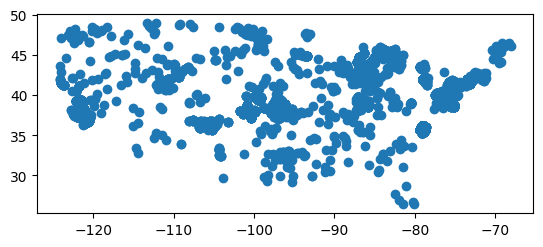

In [33]:
gdf.plot()

In [34]:
gdf.to_file(data_dir/"label.geojson", driver="GeoJSON", index=None)

In [35]:
import planetary_computer as pc
from pystac_client import Client

In [36]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

In [37]:
sample = meta.iloc[0]
sample

uid                         aabm
latitude               39.080319
longitude             -86.430867
date         2018-05-14 00:00:00
split                      train
Name: 0, dtype: object

In [39]:
import geopy.distance as D

In [40]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    distance_search = D.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(sample.latitude, sample.longitude, meter_buffer=50000)
bbox

[-87.00870397333593,
 38.629920229019866,
 -85.85302935999748,
 39.530683022908526]

In [45]:
# get our date range to search, and format correctly for query
from datetime import timedelta

def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(sample.date)
date_range

'2018-04-29/2018-05-14'

In [72]:
search = catalog.search(
    collections = ["sentinel-2-l2a"],
    bbox = bbox,
    datetime=date_range,
    query=["eo:cloud_cover<10"]
)

In [73]:
items = list(search.get_all_items())

In [74]:
len(items)

1

In [75]:
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < sample.latitude)
    & (item_details.max_lat > sample.latitude)
    & (item_details.min_long < sample.longitude)
    & (item_details.max_long > sample.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 1 returned to 1 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
0,2018-05-08,Sentinel-2B,True,"[-87.00023345437725, 38.754036048213806, -85.7..."


In [76]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2018-05-08
platform                                                       Sentinel-2B
min_long                                                        -87.000233
max_long                                                         -85.71872
min_lat                                                          38.754036
max_lat                                                          39.750268
bbox                     [-87.00023345437725, 38.754036048213806, -85.7...
item_obj                 <Item id=S2B_MSIL2A_20180508T162859_R083_T16SE...
contains_sample_point                                                 True
Name: 0, dtype: object

In [77]:
item = best_item.item_obj

In [78]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [79]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [80]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [81]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    sample.latitude, sample.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

array([[ 74,  91, 114, ...,  24,  25,  25],
       [ 71,  98, 119, ...,  24,  25,  24],
       [ 74,  81, 102, ...,  24,  24,  25],
       ...,
       [ 80,  53,  45, ...,  41,  42,  36],
       [ 92,  67,  43, ...,  49,  45,  40],
       [ 76,  73,  46, ...,  46,  39,  29]], dtype=uint8)

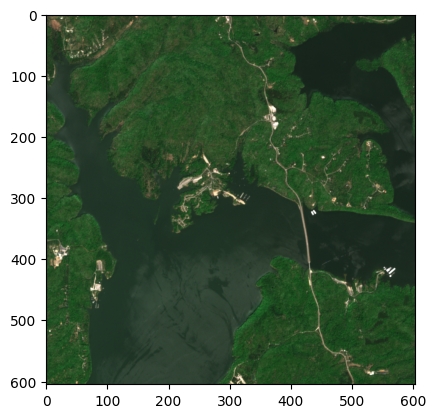

In [82]:
import numpy as np
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [84]:
gdf[gdf.uid == sample.uid]

,uid,region,severity,density,latitude,longitude,date,split,geometry
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
